In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
air_quality = pd.read_csv('Data/Almaty US Embassy Air Quality.csv')

weather_files = [
    'Data/Almaty Weather 2020-2021.csv',
    'Data/Almaty Weather 2021-2023.csv',
    'Data/Almaty Weather 2023-2024.csv'
]

weather_data = pd.concat((pd.read_csv(f) for f in weather_files), ignore_index=True)

In [3]:
print(air_quality.head())
print(air_quality.info())

       date  pm25  pm10  no2  so2  co
0  2024/4/1    59    43   13    1   6
1  2024/4/2    66    21   10    1   4
2  2024/4/3    39    31   10    1   4
3  2024/4/4    58    34   12    1   5
4  2024/4/5    63    27   10    1   3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526 entries, 0 to 1525
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1526 non-null   object
 1    pm25   1526 non-null   object
 2    pm10   1526 non-null   object
 3    no2    1526 non-null   object
 4    so2    1526 non-null   object
 5    co     1526 non-null   object
dtypes: object(6)
memory usage: 71.7+ KB
None


In [4]:
print(weather_data.head())
print(weather_data.info())

                name    datetime  tempmax  tempmin  temp  feelslikemax  \
0  Алматы, Қазақстан  2020-02-11      3.0     -6.2  -2.8           1.9   
1  Алматы, Қазақстан  2020-02-12     -0.6     -7.0  -4.8          -3.1   
2  Алматы, Қазақстан  2020-02-13      3.5     -6.0  -0.4           0.8   
3  Алматы, Қазақстан  2020-02-14      3.6     -1.3   0.4           2.4   
4  Алматы, Қазақстан  2020-02-15      2.0     -2.1  -0.7          -0.7   

   feelslikemin  feelslike  dew  humidity  ...  solarenergy  uvindex  \
0          -9.4       -6.0 -3.6      94.3  ...          9.1        4   
1         -10.6       -7.5 -6.0      91.7  ...         12.5        6   
2         -10.0       -3.9 -1.7      91.1  ...          5.4        3   
3          -5.2       -2.7 -1.0      91.1  ...         12.7        6   
4          -5.9       -3.9 -2.2      89.7  ...         12.9        6   

   severerisk              sunrise               sunset  moonphase  \
0         NaN  2020-02-11T07:57:06  2020-02-11T18:16

In [5]:
air_quality['date'] = pd.to_datetime(air_quality['date'], format='%Y/%m/%d')

In [6]:
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

In [7]:
merged_data = pd.merge(
    air_quality, 
    weather_data, 
    left_on='date', 
    right_on='datetime', 
    how='inner'
)

In [8]:
print(merged_data.isnull().sum())

date                  0
 pm25                 0
 pm10                 0
 no2                  0
 so2                  0
 co                   0
name                  0
datetime              0
tempmax               0
tempmin               0
temp                  0
feelslikemax          0
feelslikemin          0
feelslike             0
dew                   0
humidity              0
precip                0
precipprob            0
precipcover           0
preciptype          528
snow                  0
snowdepth             0
windgust              0
windspeed             0
winddir               0
sealevelpressure      0
cloudcover            0
visibility            0
solarradiation        0
solarenergy           0
uvindex               0
severerisk          684
sunrise               0
sunset                0
moonphase             0
conditions            0
description           0
icon                  0
stations              0
dtype: int64


In [9]:
merged_data.columns = merged_data.columns.str.strip()

In [10]:
object_to_numerical = ['pm25', 'pm10', 'no2', 'so2', 'co']

for col in object_to_numerical:
    merged_data[col] = merged_data[col].str.strip()
    merged_data[col].replace('', np.nan, inplace=True)

In [11]:
print(merged_data.isnull().sum())

date                  0
pm25                192
pm10                334
no2                 695
so2                 280
co                  274
name                  0
datetime              0
tempmax               0
tempmin               0
temp                  0
feelslikemax          0
feelslikemin          0
feelslike             0
dew                   0
humidity              0
precip                0
precipprob            0
precipcover           0
preciptype          528
snow                  0
snowdepth             0
windgust              0
windspeed             0
winddir               0
sealevelpressure      0
cloudcover            0
visibility            0
solarradiation        0
solarenergy           0
uvindex               0
severerisk          684
sunrise               0
sunset                0
moonphase             0
conditions            0
description           0
icon                  0
stations              0
dtype: int64


In [12]:
object_to_numerical = ['pm25', 'pm10', 'no2', 'so2', 'co']

for col in object_to_numerical:
    try:
        merged_data[col] = pd.to_numeric(merged_data[col])
    except ValueError:
        pass

In [13]:
merged_data['pm25'] = merged_data['pm25'].fillna(merged_data['pm25'].mean())
merged_data['pm10'] = merged_data['pm10'].fillna(merged_data['pm10'].mean())
merged_data['no2'] = merged_data['no2'].fillna(merged_data['no2'].mean())
merged_data['so2'] = merged_data['so2'].fillna(merged_data['so2'].mean())
merged_data['co'] = merged_data['co'].fillna(merged_data['co'].mean())
merged_data = merged_data.drop(columns=['preciptype', 'severerisk', 'name', 'sunrise', 'sunset', 'description', 'icon', 'stations'])

In [14]:
merged_data = merged_data.drop_duplicates()

In [15]:
print(merged_data.isnull().sum())

date                0
pm25                0
pm10                0
no2                 0
so2                 0
co                  0
datetime            0
tempmax             0
tempmin             0
temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
snow                0
snowdepth           0
windgust            0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
moonphase           0
conditions          0
dtype: int64


In [16]:
target = 'pm25'

features = ['temp', 'humidity', 'windspeed', 'winddir', 'precip', 'pm10', 'no2', 'so2', 'co']

In [17]:
merged_data.sort_values('date', inplace=True)

merged_data.reset_index(drop=True, inplace=True)

# Define split sizes
train_size = int(len(merged_data) * 0.6)        # 60% Training
validation_size = int(len(merged_data) * 0.2)   # 20% Validation
test_size = len(merged_data) - train_size - validation_size  # 20% Test

# Perform the splits
train_data = merged_data.iloc[:train_size]
validation_data = merged_data.iloc[train_size:train_size + validation_size]
test_data = merged_data.iloc[train_size + validation_size:]

In [18]:
# Endogenous variable (target)
y_train = train_data[target]
y_validation = validation_data[target]
y_test = test_data[target]

# Exogenous variables (features)
exog_train = train_data[features]
exog_validation = validation_data[features]
exog_test = test_data[features]

In [19]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {title}: {result[0]}')
    print(f'p-value: {result[1]}')

adf_test(y_train, title=target)

ADF Statistic for pm25: -3.093915147197574
p-value: 0.02700678427569794


In [20]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None

for order in pdq:
    try:
        model = SARIMAX(
            y_train, 
            exog=exog_train, 
            order=order, 
            enforce_stationarity=False, 
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue

print(f'Best ARIMAX order: {best_order} with AIC: {best_aic}')

Best ARIMAX order: (1, 1, 2) with AIC: 8229.902895143072


In [21]:
model_arimax = SARIMAX(
    y_train, 
    exog=exog_train, 
    order=best_order, 
    enforce_stationarity=False, 
    enforce_invertibility=False
)
arimax_result = model_arimax.fit()

# Print summary
print(arimax_result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.49811D+00    |proj g|=  1.33065D-01


 This problem is unconstrained.



At iterate    5    f=  4.48768D+00    |proj g|=  1.22460D-01

At iterate   10    f=  4.48624D+00    |proj g|=  2.74169D-02

At iterate   15    f=  4.48555D+00    |proj g|=  3.61993D-02

At iterate   20    f=  4.48505D+00    |proj g|=  1.11976D-02

At iterate   25    f=  4.48337D+00    |proj g|=  1.24827D-02

At iterate   30    f=  4.48319D+00    |proj g|=  1.55569D-02

At iterate   35    f=  4.48311D+00    |proj g|=  1.58055D-03

At iterate   40    f=  4.48306D+00    |proj g|=  2.20433D-02

At iterate   45    f=  4.48302D+00    |proj g|=  1.16731D-03

At iterate   50    f=  4.48301D+00    |proj g|=  7.04504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [22]:
# Predict on Validation Set
arimax_val_pred = arimax_result.predict(
    start=train_size,
    end=train_size + validation_size - 1,
    exog=exog_validation
)

# Forecast on Test Set
arimax_test_pred = arimax_result.forecast(
    steps=test_size,
    exog=exog_test
)

In [23]:
# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scaler on Training Features and Target
scaled_train_features = feature_scaler.fit_transform(train_data[features])
scaled_train_target = target_scaler.fit_transform(train_data[[target]])

# Transform Validation and Test Features and Target
scaled_validation_features = feature_scaler.transform(validation_data[features])
scaled_validation_target = target_scaler.transform(validation_data[[target]])

scaled_test_features = feature_scaler.transform(test_data[features])
scaled_test_target = target_scaler.transform(test_data[[target]])

# Combine Scaled Features and Target for Sequence Creation
scaled_train = np.hstack((scaled_train_features, scaled_train_target))
scaled_validation = np.hstack((scaled_validation_features, scaled_validation_target))
scaled_test = np.hstack((scaled_test_features, scaled_test_target))

In [24]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Features
        y.append(data[i+seq_length, -1])     # Target
    return np.array(X), np.array(y)

seq_length = 5  # Number of time steps

# Create Sequences
X_train_lstm, y_train_lstm = create_sequences(scaled_train, seq_length)
X_validation_lstm, y_validation_lstm = create_sequences(scaled_validation, seq_length)
X_test_lstm, y_test_lstm = create_sequences(scaled_test, seq_length)

In [25]:
# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model_lstm.fit(
    X_train_lstm, y_train_lstm, 
    epochs=20, 
    batch_size=64, 
    validation_data=(X_validation_lstm, y_validation_lstm),
    verbose=1
)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0627 - val_loss: 0.0221
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.0129
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 0.0123
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - val_loss: 0.0104
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0100
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0101
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0094
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_l

In [26]:
# Predict on Validation and Test Data
lstm_val_pred = model_lstm.predict(X_validation_lstm)
lstm_test_pred = model_lstm.predict(X_test_lstm)

# Inverse Transform Predictions
lstm_val_pred_rescaled = target_scaler.inverse_transform(lstm_val_pred)
lstm_test_pred_rescaled = target_scaler.inverse_transform(lstm_test_pred)

# Inverse Transform Actual Values
y_validation_rescaled = target_scaler.inverse_transform(y_validation_lstm.reshape(-1, 1))
y_test_rescaled = target_scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [27]:
# Prepare Meta-Features from Validation Set
arimax_val_pred = arimax_val_pred.iloc[seq_length:].values
arimax_test_pred = arimax_test_pred.iloc[seq_length:].values

meta_features_val = np.column_stack((arimax_val_pred, lstm_val_pred_rescaled.flatten()))
y_meta_val = y_validation_rescaled.flatten()

# Initialize and Train the Meta-Model
meta_model = LinearRegression()
meta_model.fit(meta_features_val, y_meta_val)

LinearRegression()

In [28]:
# Prepare Meta-Features from Test Set
meta_features_test = np.column_stack((arimax_test_pred, lstm_test_pred_rescaled.flatten()))

# Make Hybrid Predictions
hybrid_predictions = meta_model.predict(meta_features_test)

In [29]:
# ARIMAX Evaluation
arimax_rmse = np.sqrt(mean_squared_error(y_test_rescaled, arimax_test_pred))
arimax_mae = mean_absolute_error(y_test_rescaled, arimax_test_pred)

# LSTM Evaluation
lstm_rmse = np.sqrt(mean_squared_error(y_test_rescaled, lstm_test_pred_rescaled))
lstm_mae = mean_absolute_error(y_test_rescaled, lstm_test_pred_rescaled)

# Hybrid Model Evaluation
hybrid_rmse = np.sqrt(mean_squared_error(y_test_rescaled, hybrid_predictions))
hybrid_mae = mean_absolute_error(y_test_rescaled, hybrid_predictions)

print(f"ARIMAX RMSE: {arimax_rmse:.2f}, MAE: {arimax_mae:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")
print(f"Hybrid RMSE: {hybrid_rmse:.2f}, MAE: {hybrid_mae:.2f}")


ARIMAX RMSE: 35.03, MAE: 31.61
LSTM RMSE: 20.98, MAE: 16.60
Hybrid RMSE: 18.93, MAE: 15.11


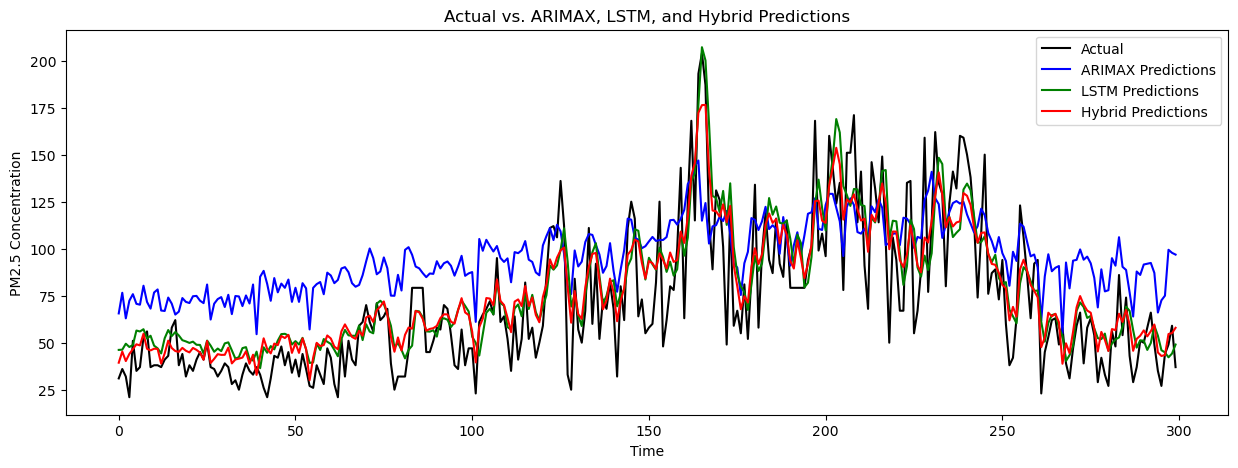

In [30]:
plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled, label='Actual', color='black')
plt.plot(arimax_test_pred, label='ARIMAX Predictions', color='blue')
plt.plot(lstm_test_pred_rescaled, label='LSTM Predictions', color='green')
plt.plot(hybrid_predictions, label='Hybrid Predictions', color='red')
plt.legend()
plt.title('Actual vs. ARIMAX, LSTM, and Hybrid Predictions')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.show()
